In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GRU, Dense, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\idriscoded\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\idriscoded\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#importation of the dataset
tinder_review = pd.read_csv('C:/nlp/TINDER_REVIEWS.csv')

In [3]:
#printing the dataset
tinder_review.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,f463cdfc-bd0a-42e0-a951-7de849cd95fd,152618553977019693742,A Google user,Finally the real Tinder is on Android,5,4,1.0,2013-07-15 21:07:56
1,1,91829d43-289a-42af-b5ab-8f548339dd76,234382942865437071667,A Google user,Crashes. Doesn't load. Total failure. Take it ...,1,0,1.0,2013-07-15 22:20:31
2,2,cfd8526b-e84b-4d4d-9989-3a5dc0a89b1a,174473604608358796368,A Google user,Keeps crashing.,1,0,1.0,2013-07-15 22:27:15
3,3,e418f4c2-78ca-4e93-93fa-d522d2ef2cb2,286593453219054880269,A Google user,Tinder is extremely buggy on the galaxy S4 act...,1,0,1.0,2013-07-15 22:43:41
4,4,c9c6a2e3-4d65-4d3c-b434-d027dd7d81a9,167276875678680630145,A Google user,Best app ever finally on android,5,2,1.0,2013-07-15 23:02:49


In [4]:
tinder_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603841 entries, 0 to 603840
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          603841 non-null  int64 
 1   review_id           603841 non-null  object
 2   pseudo_author_id    603841 non-null  object
 3   author_name         603841 non-null  object
 4   review_text         602482 non-null  object
 5   review_rating       603841 non-null  int64 
 6   review_likes        603841 non-null  int64 
 7   author_app_version  479124 non-null  object
 8   review_timestamp    603841 non-null  object
dtypes: int64(3), object(6)
memory usage: 41.5+ MB


In [5]:
tinder_review.columns

Index(['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name',
       'review_text', 'review_rating', 'review_likes', 'author_app_version',
       'review_timestamp'],
      dtype='object')

In [6]:
#checking the dataset shape
tinder_review.shape

(603841, 9)

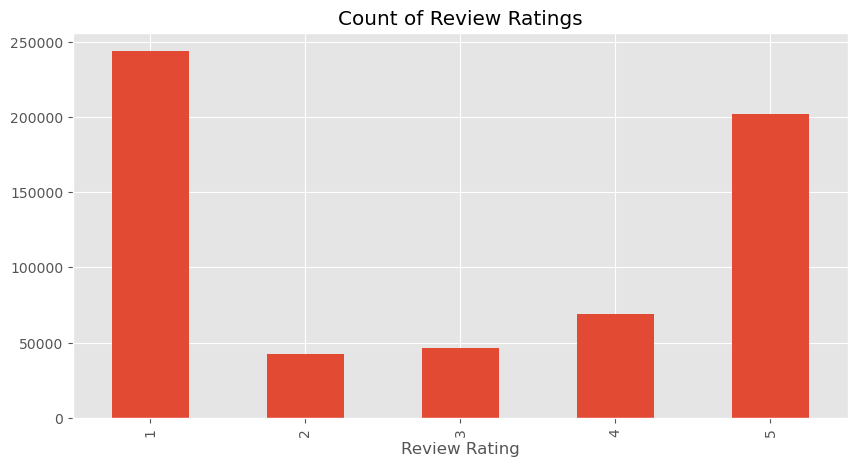

In [7]:
#plot showing the review ratings
ax = tinder_review['review_rating'].value_counts().sort_index().plot(kind='bar', title = 'Count of Review Ratings', figsize = (10,5))
ax.set_xlabel('Review Rating')
plt.show()

In [8]:
#counts of the review ratings
tinder_review['review_rating'].value_counts()

review_rating
1    243766
5    201971
4     68905
3     46526
2     42673
Name: count, dtype: int64

In [9]:
#checking for null values
tinder_review.isnull().sum()

Unnamed: 0                 0
review_id                  0
pseudo_author_id           0
author_name                0
review_text             1359
review_rating              0
review_likes               0
author_app_version    124717
review_timestamp           0
dtype: int64

In [10]:
#want to sample out 15% of the dataset for my analyses
sample_percentage = 0.15

In [11]:
sampled_df = tinder_review.sample(frac=sample_percentage, random_state=42)

In [12]:
sampled_df.to_csv('sampled_dataset.csv', index=False)

In [13]:
sampled_df

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
262405,262405,3962bf69-e186-464e-8d15-196613c354d8,169334117986438708611,A Google user,You guys go to far. My identity should be priv...,1,0,9.7.0,2018-08-27 01:03:02
521684,521684,337451cc-3682-4f6f-9ebf-92cac812d2c6,201643054288577466290,Jo********ss,Massively over priced and they charge more if ...,1,0,13.6.1,2022-05-21 06:04:08
517564,517564,8c0fb7cd-f26f-46ab-bc34-9cfb829aa4ff,283424615056561871692,Zo********us,I understand paying to get your profile viewed...,1,0,13.6.1,2022-04-23 18:57:54
195119,195119,bf8f307d-99ce-4bd1-a386-1d068e9798a4,333825338029057555532,A Google user,Have seen an important person whom I've missed...,5,0,7.3.0,2017-07-22 18:54:35
219343,219343,e7ae4b69-b6d1-4795-ad0c-925e8d6573cf,111305770771093257475,A Google user,Good ap,5,0,8.1.1,2017-11-28 04:26:24
...,...,...,...,...,...,...,...,...,...
441309,441309,c119ff9a-e4a5-4c0b-b8c0-87bcb58f076d,111584902704034448771,T****o,Damn you down bad bro,5,0,NaN,2020-12-21 23:45:45
68676,68676,9462aa03-fbf1-448d-8c8f-772eda1fe128,353327249092636428517,A Google user,You're not finding people near me,2,0,NaN,2015-05-31 09:33:03
390460,390460,bee51abc-e16f-4847-95c1-13e0547fac8a,328860434435920049283,A Google user,Fantastic,5,0,NaN,2020-03-14 17:10:36
484848,484848,712d6490-d8ff-411d-962f-2880f7f21833,201713703257673562222,Ma******ox,Don't bother. This thing is filled with bots a...,1,2,12.15.0,2021-09-12 13:33:00


In [14]:
#the sampled datasets review rating counts
sampled_df['review_rating'].value_counts()

review_rating
1    36604
5    30182
4    10266
3     7139
2     6385
Name: count, dtype: int64

In [15]:
#checking the sampled dataset shape
sampled_df.shape

(90576, 9)

In [16]:
#checking for null values
sampled_df.isnull().sum()

Unnamed: 0                0
review_id                 0
pseudo_author_id          0
author_name               0
review_text             185
review_rating             0
review_likes              0
author_app_version    18820
review_timestamp          0
dtype: int64

In [17]:
#dropping all null values
sampled_df = sampled_df.dropna()

In [18]:
#sampled dataset shape after dropping all null values
sampled_df.shape

(71585, 9)

In [19]:
#checking for duplicate
duplicate_rows = sampled_df.duplicated(subset=['review_id', 'pseudo_author_id'], keep=False)
print(sampled_df[duplicate_rows])

Empty DataFrame
Columns: [Unnamed: 0, review_id, pseudo_author_id, author_name, review_text, review_rating, review_likes, author_app_version, review_timestamp]
Index: []


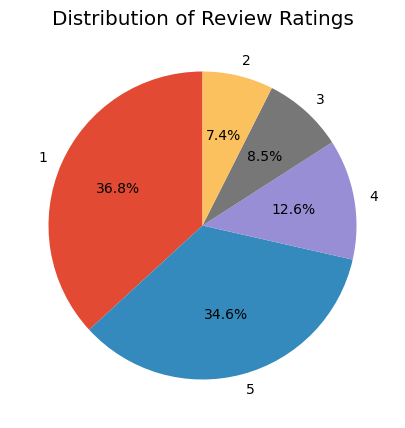

In [20]:
labels = sampled_df['review_rating'].value_counts().index
sizes = sampled_df['review_rating'].value_counts().values

plt.figure(figsize=(10, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Review Ratings')
plt.show()

## Pre Processing

In [21]:
#removing special characters and Stopwords in review text
def data_processing(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(filtered_words)

# Applying the function to the 'Text' column in the DataFrame
sampled_df['Processed_Text'] = sampled_df['review_text'].apply(data_processing)
sampled_df

C:\Users\idriscoded\AppData\Local\Temp\ipykernel_9816\1763133365.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['Processed_Text'] = sampled_df['review_text'].apply(data_processing)


,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Processed_Text
262405,262405,3962bf69-e186-464e-8d15-196613c354d8,169334117986438708611,A Google user,You guys go to far. My identity should be priv...,1,0,9.7.0,2018-08-27 01:03:02,guys go far identity private fk want info go d...
521684,521684,337451cc-3682-4f6f-9ebf-92cac812d2c6,201643054288577466290,Jo********ss,Massively over priced and they charge more if ...,1,0,13.6.1,2022-05-21 06:04:08,massively priced charge older form discriminat...
517564,517564,8c0fb7cd-f26f-46ab-bc34-9cfb829aa4ff,283424615056561871692,Zo********us,I understand paying to get your profile viewed...,1,0,13.6.1,2022-04-23 18:57:54,understand paying get profile viewed often pay...
195119,195119,bf8f307d-99ce-4bd1-a386-1d068e9798a4,333825338029057555532,A Google user,Have seen an important person whom I've missed...,5,0,7.3.0,2017-07-22 18:54:35,seen important person ive missed ages
219343,219343,e7ae4b69-b6d1-4795-ad0c-925e8d6573cf,111305770771093257475,A Google user,Good ap,5,0,8.1.1,2017-11-28 04:26:24,good ap
...,...,...,...,...,...,...,...,...,...,...
139030,139030,ad4520d3-7687-4095-97d4-3de9ef971ca0,324635397014904907577,A Google user,I have to log in using facebook??? Really??? W...,1,1,5.3.5,2016-08-18 05:55:27,log using facebook really choice dont even use...
281621,281621,0ad7edd0-b53a-45c7-aced-71d5b9c57484,933925189353043468198,A Google user,Love it,5,0,10.0.1,2018-11-11 19:48:41,love
578242,578242,95f7eaca-7dcf-49ce-879c-0e8cd94b5ccb,205998895652290705329,As********os,very good,5,0,14.8.0,2023-05-13 23:28:42,good
345777,345777,cd4be391-8004-43f5-8b72-50f57785a85f,271841311370488942334,A Google user,good,5,0,10.19.0,2019-07-28 04:01:05,good


In [22]:
#lemmatization, that is removing the words into their base form
# Function to perform lemmatization on a text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Create a new column 'Lemmatized_Text' in the DataFrame
sampled_df['Text1'] = sampled_df['Processed_Text'].apply(lemmatize_text)
sampled_df

C:\Users\idriscoded\AppData\Local\Temp\ipykernel_9816\4008672919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['Text1'] = sampled_df['Processed_Text'].apply(lemmatize_text)


,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Processed_Text,Text1
262405,262405,3962bf69-e186-464e-8d15-196613c354d8,169334117986438708611,A Google user,You guys go to far. My identity should be priv...,1,0,9.7.0,2018-08-27 01:03:02,guys go far identity private fk want info go d...,guy go far identity private fk want info go di...
521684,521684,337451cc-3682-4f6f-9ebf-92cac812d2c6,201643054288577466290,Jo********ss,Massively over priced and they charge more if ...,1,0,13.6.1,2022-05-21 06:04:08,massively priced charge older form discriminat...,massively priced charge older form discriminat...
517564,517564,8c0fb7cd-f26f-46ab-bc34-9cfb829aa4ff,283424615056561871692,Zo********us,I understand paying to get your profile viewed...,1,0,13.6.1,2022-04-23 18:57:54,understand paying get profile viewed often pay...,understand paying get profile viewed often pay...
195119,195119,bf8f307d-99ce-4bd1-a386-1d068e9798a4,333825338029057555532,A Google user,Have seen an important person whom I've missed...,5,0,7.3.0,2017-07-22 18:54:35,seen important person ive missed ages,seen important person ive missed age
219343,219343,e7ae4b69-b6d1-4795-ad0c-925e8d6573cf,111305770771093257475,A Google user,Good ap,5,0,8.1.1,2017-11-28 04:26:24,good ap,good ap
...,...,...,...,...,...,...,...,...,...,...,...
139030,139030,ad4520d3-7687-4095-97d4-3de9ef971ca0,324635397014904907577,A Google user,I have to log in using facebook??? Really??? W...,1,1,5.3.5,2016-08-18 05:55:27,log using facebook really choice dont even use...,log using facebook really choice dont even use...
281621,281621,0ad7edd0-b53a-45c7-aced-71d5b9c57484,933925189353043468198,A Google user,Love it,5,0,10.0.1,2018-11-11 19:48:41,love,love
578242,578242,95f7eaca-7dcf-49ce-879c-0e8cd94b5ccb,205998895652290705329,As********os,very good,5,0,14.8.0,2023-05-13 23:28:42,good,good
345777,345777,cd4be391-8004-43f5-8b72-50f57785a85f,271841311370488942334,A Google user,good,5,0,10.19.0,2019-07-28 04:01:05,good,good


In [23]:
#defining sentiment
rating_scale = {1: 'negative', 2: 'negative', 3: 'negative', 4: 'positive', 5: 'positive'}
sampled_df['scale_rating'] = sampled_df['review_rating'].replace(rating_scale)
sampled_df

C:\Users\idriscoded\AppData\Local\Temp\ipykernel_9816\4148562888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['scale_rating'] = sampled_df['review_rating'].replace(rating_scale)


,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Processed_Text,Text1,scale_rating
262405,262405,3962bf69-e186-464e-8d15-196613c354d8,169334117986438708611,A Google user,You guys go to far. My identity should be priv...,1,0,9.7.0,2018-08-27 01:03:02,guys go far identity private fk want info go d...,guy go far identity private fk want info go di...,negative
521684,521684,337451cc-3682-4f6f-9ebf-92cac812d2c6,201643054288577466290,Jo********ss,Massively over priced and they charge more if ...,1,0,13.6.1,2022-05-21 06:04:08,massively priced charge older form discriminat...,massively priced charge older form discriminat...,negative
517564,517564,8c0fb7cd-f26f-46ab-bc34-9cfb829aa4ff,283424615056561871692,Zo********us,I understand paying to get your profile viewed...,1,0,13.6.1,2022-04-23 18:57:54,understand paying get profile viewed often pay...,understand paying get profile viewed often pay...,negative
195119,195119,bf8f307d-99ce-4bd1-a386-1d068e9798a4,333825338029057555532,A Google user,Have seen an important person whom I've missed...,5,0,7.3.0,2017-07-22 18:54:35,seen important person ive missed ages,seen important person ive missed age,positive
219343,219343,e7ae4b69-b6d1-4795-ad0c-925e8d6573cf,111305770771093257475,A Google user,Good ap,5,0,8.1.1,2017-11-28 04:26:24,good ap,good ap,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
139030,139030,ad4520d3-7687-4095-97d4-3de9ef971ca0,324635397014904907577,A Google user,I have to log in using facebook??? Really??? W...,1,1,5.3.5,2016-08-18 05:55:27,log using facebook really choice dont even use...,log using facebook really choice dont even use...,negative
281621,281621,0ad7edd0-b53a-45c7-aced-71d5b9c57484,933925189353043468198,A Google user,Love it,5,0,10.0.1,2018-11-11 19:48:41,love,love,positive
578242,578242,95f7eaca-7dcf-49ce-879c-0e8cd94b5ccb,205998895652290705329,As********os,very good,5,0,14.8.0,2023-05-13 23:28:42,good,good,positive
345777,345777,cd4be391-8004-43f5-8b72-50f57785a85f,271841311370488942334,A Google user,good,5,0,10.19.0,2019-07-28 04:01:05,good,good,positive


In [24]:
#word cloud for positive sentiment
positive_text = ' '.join(sampled_df[sampled_df['scale_rating']=='positive']['Text1'])

In [25]:
wordcloud_positive = WordCloud(width=1600, height=800, background_color='black').generate(positive_text)

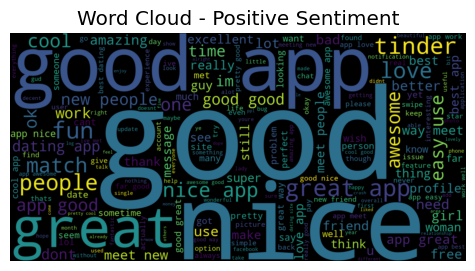

In [26]:
plt.figure(figsize=(20, 15))

plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')
plt.show()

In [27]:
#word cloud for negative sentiment
negative_text = ' '.join(sampled_df[sampled_df['scale_rating']=='negative']['Text1'])

In [28]:
wordcloud_negative = WordCloud(width=1600, height=800, background_color='black').generate(negative_text)

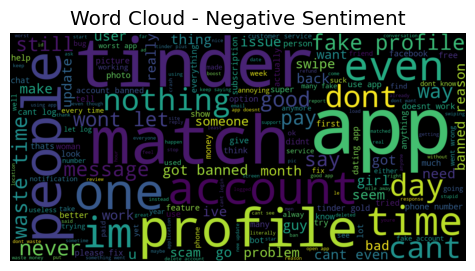

In [29]:
plt.figure(figsize=(20, 15))

plt.subplot(131)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')
plt.show()

In [30]:
#lebelling my X,y for the training i.e the text and the sentiment
X = sampled_df['Text1']
y = sampled_df['scale_rating']

In [31]:
#count of the sentiments
sampled_df['scale_rating'].value_counts()

scale_rating
negative    37762
positive    33823
Name: count, dtype: int64

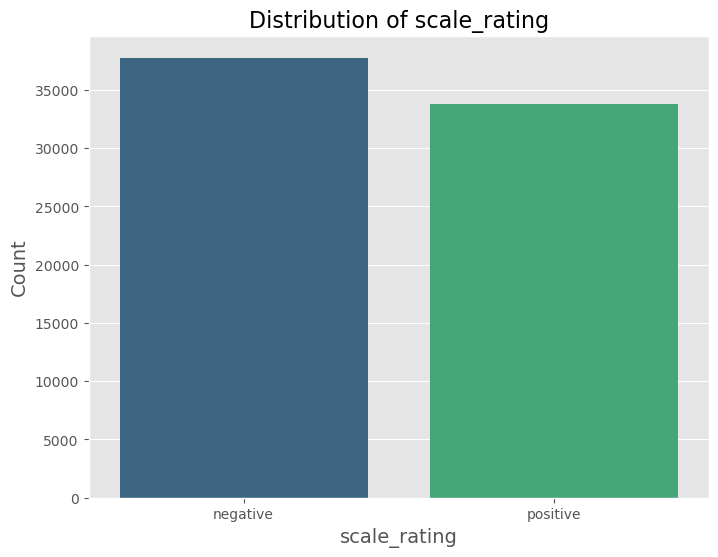

In [32]:
# Plot showing the distribution of scale_rating(i.e sentiment)
plt.figure(figsize=(8, 6))
sns.countplot(x='scale_rating', data=sampled_df, palette='viridis')
plt.title('Distribution of scale_rating', fontsize=16)
plt.xlabel('scale_rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Number of unique words: 25910


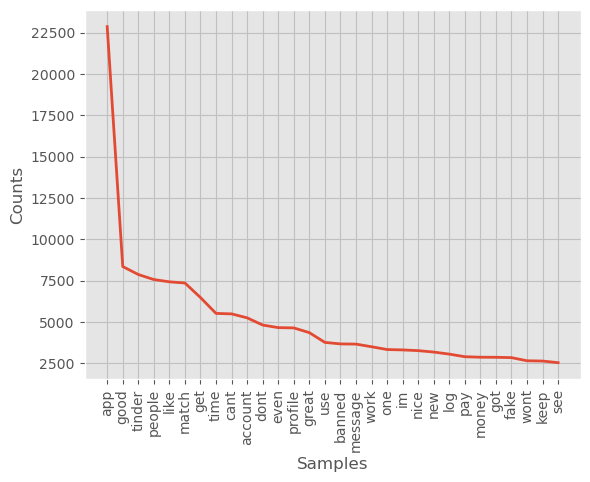

In [33]:
#plot showing the counts of most frequent words
all_text = ' '.join(X)  # Combine all text sequences into one string

# Tokenize the text into words
tokens = word_tokenize(all_text)

# Calculate the frequency distribution of words
freq_dist = FreqDist(tokens)

# Display the number of unique words
unique_word_count = len(freq_dist)
print(f"Number of unique words: {unique_word_count}")

# Optionally, visualize the frequency distribution
freq_dist.plot(30, cumulative=False)
plt.show()

In [34]:
# Encode the target variable to binary(i.e 0 and 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# counts of most common 10 words
all_text = ' '.join(X)  # Combine all text sequences into one string

# Tokenize the text into words
tokens = word_tokenize(all_text)

# Calculate word frequencies
freq_dist = FreqDist(tokens)

# Display the most common words and their frequencies
print(freq_dist.most_common(10))

[('app', 22861), ('good', 8360), ('tinder', 7878), ('people', 7573), ('like', 7436), ('match', 7364), ('get', 6485), ('time', 5525), ('cant', 5498), ('account', 5258)]


In [36]:
#tokenizing using a keras tokenizer(it is used to vectorize a text corpus into a sequence of integers. )
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

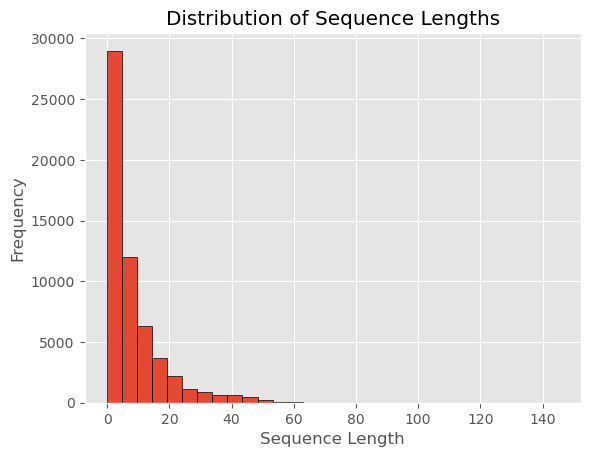

Summary Statistics:
Mean: 8.178075015715583
Median: 4.0
Standard Deviation: 9.832788641490009
Minimum: 0
Maximum: 145


In [37]:
#plot showing the sequence length after using tokenizer
sequence_lengths = [len(seq) for seq in X_train_seq]

# Plot a histogram
plt.hist(sequence_lengths, bins=30, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()
# Display summary statistics
print("Summary Statistics:")
print("Mean:", np.mean(sequence_lengths))
print("Median:", np.median(sequence_lengths))
print("Standard Deviation:", np.std(sequence_lengths))
print("Minimum:", np.min(sequence_lengths))
print("Maximum:", np.max(sequence_lengths))

In [38]:
# Pad sequences to ensure consistent input size for the LSTM model
X_train_padded = pad_sequences(X_train_seq, maxlen=28, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=28, padding='post')

## LSTM MODEL

Epoch 1/50
1790/1790 [==============================] - 71s 35ms/step - loss: 0.3507 - accuracy: 0.8590 - val_loss: 0.3301 - val_accuracy: 0.8702
Epoch 2/50
1790/1790 [==============================] - 51s 29ms/step - loss: 0.2992 - accuracy: 0.8855 - val_loss: 0.3219 - val_accuracy: 0.8721
Epoch 3/50
1790/1790 [==============================] - 68s 38ms/step - loss: 0.2791 - accuracy: 0.8930 - val_loss: 0.3317 - val_accuracy: 0.8719
Epoch 4/50
1790/1790 [==============================] - 53s 30ms/step - loss: 0.2624 - accuracy: 0.8996 - val_loss: 0.3390 - val_accuracy: 0.8698
Epoch 5/50
448/448 [==============================] - 3s 7ms/step - loss: 0.3219 - accuracy: 0.8721
Test Loss: 0.3219
Test Accuracy: 87.21%


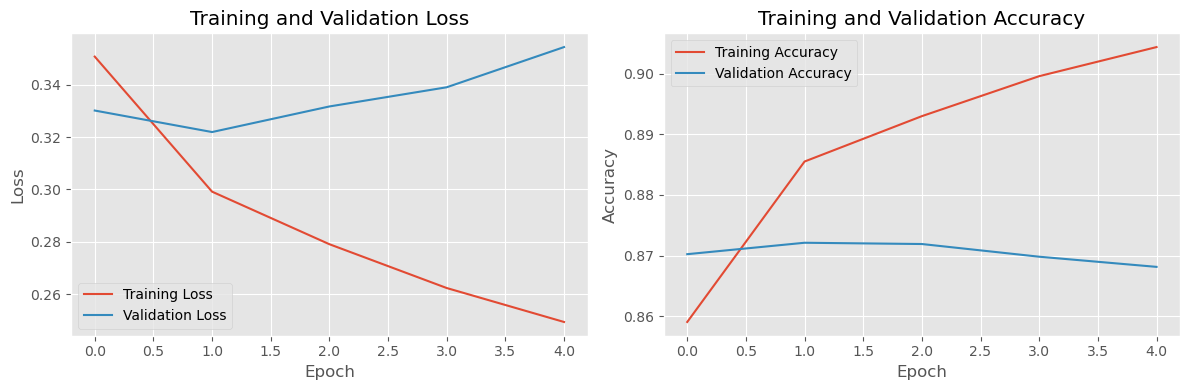

In [39]:
# Defining the model
lstm_model = Sequential()

# Adding an Embedding layer
embedding_dim = 100
lstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=28))

# Adding an LSTM layer
lstm_model.add(LSTM(units=64))

# Adding a Dense layer for the output
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Defining EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model with early stopping
history = lstm_model.fit(
    X_train_padded, y_train, epochs=50, batch_size=32,
    validation_data=(X_test_padded, y_test), callbacks=[early_stopping], verbose=1
)

# Evaluating the model on the test set
loss, accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Plot showing training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot showing training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## GRU MODEL

Epoch 1/50
1790/1790 [==============================] - 49s 26ms/step - loss: 0.3575 - accuracy: 0.8519 - val_loss: 0.3254 - val_accuracy: 0.8724
Epoch 2/50
1790/1790 [==============================] - 49s 27ms/step - loss: 0.2937 - accuracy: 0.8878 - val_loss: 0.3180 - val_accuracy: 0.8750
Epoch 3/50
1790/1790 [==============================] - 57s 32ms/step - loss: 0.2722 - accuracy: 0.8959 - val_loss: 0.3217 - val_accuracy: 0.8734
Epoch 4/50
1790/1790 [==============================] - 53s 30ms/step - loss: 0.2543 - accuracy: 0.9030 - val_loss: 0.3400 - val_accuracy: 0.8722
Epoch 5/50
448/448 [==============================] - 3s 6ms/step - loss: 0.3180 - accuracy: 0.8750
Test Loss: 0.3180
Test Accuracy: 87.50%


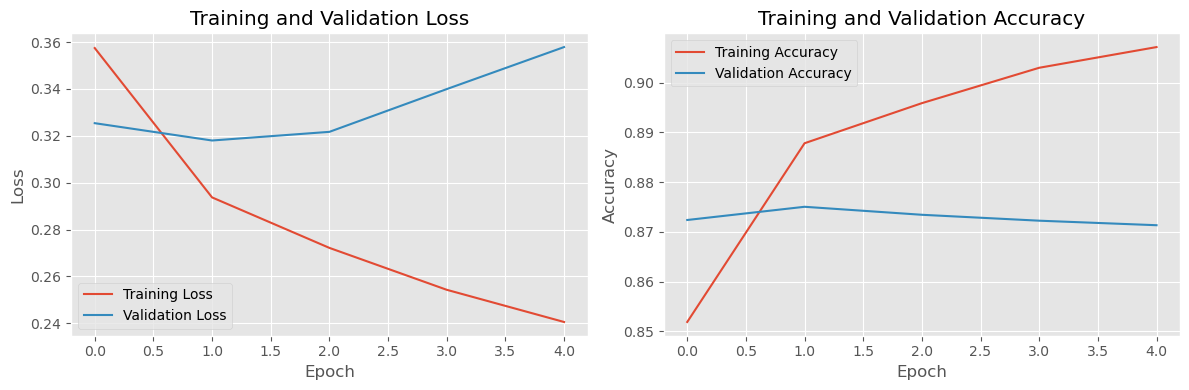

In [40]:
# Defining the model
gru_model = Sequential()

# Adding an Embedding layer
embedding_dim = 100  # Adjust based on your preference
gru_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=28))

# Adding a GRU layer
gru_model.add(GRU(units=64))

# Adding a Dense layer for the output
gru_model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Defining EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model with early stopping
history = gru_model.fit(
    X_train_padded, y_train, epochs=50, batch_size=32,
    validation_data=(X_test_padded, y_test), callbacks=[early_stopping], verbose=1
)

# Evaluating the model on the test set
loss, accuracy = gru_model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Plot showing training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot showing training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Evaluating LSTM model on the test set
lstm_predictions = (lstm_model.predict(X_test_padded) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_precision = precision_score(y_test, lstm_predictions)
lstm_recall = recall_score(y_test, lstm_predictions)
lstm_f1 = f1_score(y_test, lstm_predictions)
lstm_roc_auc = roc_auc_score(y_test, lstm_model.predict(X_test_padded))

# Evaluating GRU model on the test set
gru_predictions = (gru_model.predict(X_test_padded) > 0.5).astype(int)
gru_accuracy = accuracy_score(y_test, gru_predictions)
gru_precision = precision_score(y_test, gru_predictions)
gru_recall = recall_score(y_test, gru_predictions)
gru_f1 = f1_score(y_test, gru_predictions)
gru_roc_auc = roc_auc_score(y_test, gru_model.predict(X_test_padded))

# Display comparison metrics
print("LSTM Model:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")
print(f"F1 Score: {lstm_f1:.4f}")
print()

print("GRU Model:")
print(f"Accuracy: {gru_accuracy:.4f}")
print(f"Precision: {gru_precision:.4f}")
print(f"Recall: {gru_recall:.4f}")
print(f"F1 Score: {gru_f1:.4f}")
print()

448/448 [==============================] - 2s 5ms/step
LSTM Model:
Accuracy: 0.8721
Precision: 0.8453
Recall: 0.8938
F1 Score: 0.8689

GRU Model:
Accuracy: 0.8750
Precision: 0.8490
Recall: 0.8957
F1 Score: 0.8717

